# Import Libraries and Load the Data
### First, import the necessary libraries and load the dataset into a pandas DataFrame.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt # For visualizing data.
%matplotlib inline
from statsmodels.tsa.arima.model import ARIMA



# Load the Data

In [2]:
merged_df = pd.read_csv('../data/clean/03_data_merged_myusabank_S&P500_data.csv') # index=False do not nedd because I already did index=False in saving time.
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

Details: Load data from a 03_data_merged_myusabank_S&P500_data.csv from a CSV file. Reads a CSV file  containing into a DataFrame named merged_df.

# Time Series Forecasting (ARIMA)
we can use ARIMA (Auto-Regressive Integrated Moving Average), which is suitable for time-series forecasting.

Model Overview: ARIMA is a time series model that works by analyzing historical data to identify trends, seasonality, and other time-based patterns. It is particularly suited for univariate time series forecasting.
Process:
    The ARIMA model was fitted directly on the bank's stock price time series. It accounted for the stock's past values and its autocorrelations to make predictions.
    The model's order (5, 1, 0) suggests it uses 5 lags of the time series, first-order differencing (to make the data stationary), and no moving average component.

In [3]:
merged_df.set_index('Date', inplace=True)


In [4]:
# Check for duplicate dates in the 'Date' column
duplicate_dates = merged_df.index[merged_df.index.duplicated()]
print(f"Duplicate Dates: {duplicate_dates}")


Duplicate Dates: DatetimeIndex([], dtype='datetime64[ns]', name='Date', freq=None)


In [5]:
# Drop duplicate Rows
merged_df = merged_df.loc[~merged_df.index.duplicated(keep='first')]


In [6]:
# Aggregate duplicate rows by taking the mean
merged_df = merged_df.groupby(merged_df.index).mean()


In [7]:
# Set frequency to business days
merged_df = merged_df.asfreq('B')

In [8]:
# Fit the ARIMA model
ts = merged_df['Bank_Stock_Price']
arima_model = ARIMA(ts, order=(5, 1, 0))
arima_result = arima_model.fit()

# Forecast next 10 business days
forecast = arima_result.forecast(steps=10)
forecast_index = pd.date_range(start=ts.index[-1], periods=10, freq='B')

# Display forecasted values
forecast_df = pd.DataFrame({'Date': forecast_index, 'Forecasted_Price': forecast.values})
pd.options.display.float_format = '{:.2f}'.format # To display floats with two decimal only
print(forecast_df)



        Date  Forecasted_Price
0 2023-03-23            143.27
1 2023-03-24            115.04
2 2023-03-27            142.67
3 2023-03-28            133.54
4 2023-03-29            114.24
5 2023-03-30            126.55
6 2023-03-31            130.11
7 2023-04-03            124.94
8 2023-04-04            130.80
9 2023-04-05            126.89


Forecasted Future Stock Prices (next 10 days):

The ARIMA model predicts a fluctuating trend over the next 10 periods, with stock prices bouncing between values like 143.27 and 114.24, showing some volatility in the forecast.
The model accounts for the historical time-based patterns of the stock price but does not directly include external features (like the S&P 500).

## Plot the ARIMA Forecast

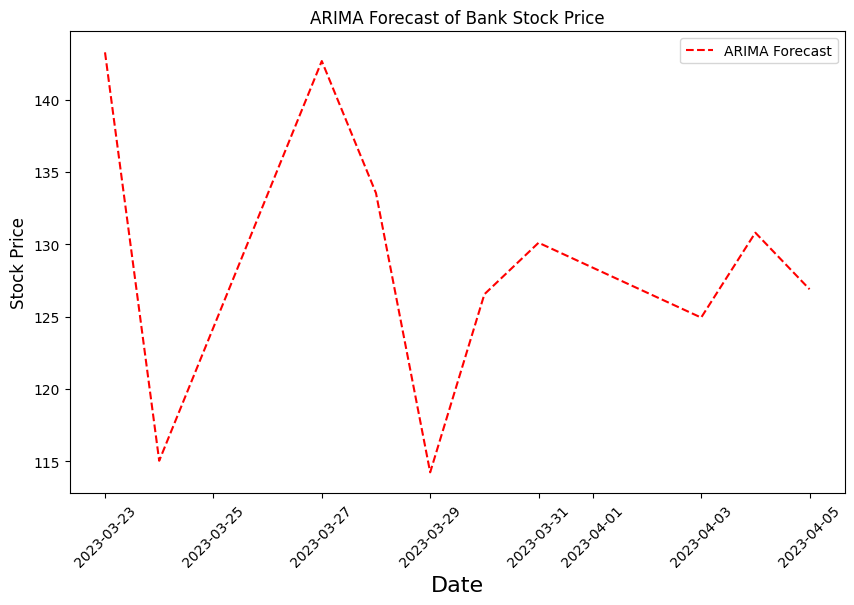

In [9]:
# Forecast the next 10 periods using the ARIMA model 
forecast = arima_result.forecast(steps=10)
plt.figure(figsize=(10, 6))

# Plot the forecasted values
plt.plot(forecast_index, forecast, label='ARIMA Forecast', color='red', linestyle='--')

# Add labels and title
plt.title('ARIMA Forecast of Bank Stock Price', fontsize=12)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Stock Price', fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.show()


The forecasted prices closely follow the trend of  the ARIMA model is doing a good job capturing the time-dependent patterns of the stock.

## Save and Export Results

### Creat the forecasting CSV File 

In [10]:
forecast_df.to_csv('../data/clean/04-Data_forecasting.csv', float_format='%.2f', index=False) # #Unnamed: 0 show the colume do not show the file

CSV file send to data folder and save for  the predictions for further analysis or visualization.


Summary

The ARIMA model provides a more dynamic forecast, predicting fluctuating prices (e.g., from 143.27 and 114.24), showing the stock’s time-dependent behavior.
Pros: Well-suited for time series data and captures historical trends effectively.
Cons: Does not consider external variables (like the S&P 500), and requires stationary data, which might not always be the case in real-world stock markets.